<a href="https://colab.research.google.com/github/AritraSarkar1203/Debutanizer_Column/blob/main/NARX__GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [827]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, knn_graph
from sklearn.preprocessing import StandardScaler

In [828]:
import pandas as pd
import numpy as np

df=pd.read_csv('/content/debutanizer_data (1).txt', sep='\s+') # Assuming space/whitespace delimited

# Convert all columns to numeric, coercing errors
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop any rows with NaN values that resulted from coercion
df.dropna(inplace=True)


inputs=df.iloc[:,:-1]
outputs=df.iloc[:,-1]

# Convert inputs and outputs to numpy arrays for easier slicing
inputs_np = inputs.values
outputs_np = outputs.values

print(f"Loaded dataset shape: {inputs.shape}, Output shape: {outputs.shape}")

Loaded dataset shape: (2394, 7), Output shape: (2394,)


In [829]:
n_u=2 #past input steps
n_y=1 #PAST OUTPUT STEPS

lagged_features = []
lagged_outputs = []


for t in range(max(n_u, n_y), len(df)):
    u_lag = inputs_np[t - n_u:t, :].flatten()
    y_lag = outputs_np[t - n_y:t].flatten() # Corrected slicing for outputs
    lagged = np.concatenate([u_lag, y_lag])
    lagged_features.append(lagged.astype(float)) # Ensure numeric type
    lagged_outputs.append(outputs_np[t].astype(float)) # Ensure numeric type

X = np.array(lagged_features)
y = np.array(lagged_outputs)

print(f"Lagged Feature shape: {X.shape}, Output shape: {y.shape}")

Lagged Feature shape: (2392, 15), Output shape: (2392,)


In [830]:
train_ratio = 0.8
train_size = int(train_ratio * len(X))

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [831]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)) # Reshape y_train
y_test = scaler_y.transform(y_test.reshape(-1, 1))     # Reshape y_test

In [832]:

from sklearn.neighbors import NearestNeighbors
def build_edge_index(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k + 1).fit(X)
    _, indices = nbrs.kneighbors(X)

    edge_list = []
    for i, neighbors in enumerate(indices):
        for j in neighbors[1:]:  # Skip self
            edge_list.append([i, j])
    return torch.tensor(edge_list, dtype=torch.long).t().contiguous()

edge_index_train = build_edge_index(X_train)
edge_index_test = build_edge_index(X_test)

In [833]:
data_train = Data(x=torch.tensor(X_train, dtype=torch.float),
                  edge_index=edge_index_train,
                  y=torch.tensor(y_train, dtype=torch.float))

data_test = Data(x=torch.tensor(X_test, dtype=torch.float),
                 edge_index=edge_index_test,
                 y=torch.tensor(y_test, dtype=torch.float))

train_loader = DataLoader([data_train], batch_size=1)
test_loader = DataLoader([data_test], batch_size=1)

In [834]:
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GNNModel(nn.Module):
     def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout_rate):
        super(GNNModel, self).__init__()
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate

        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.conv_layers.append(GCNConv(hidden_channels, hidden_channels))
        if num_layers > 1:
            self.conv_layers.append(GCNConv(hidden_channels, out_channels))
        else:
            self.conv_layers = nn.ModuleList([GCNConv(in_channels, out_channels)])


        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)


     def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for i, conv in enumerate(self.conv_layers):
            x = conv(x, edge_index)
            if i < len(self.conv_layers) - 1:
                x = self.relu(x)
                x = self.dropout(x)
        return x

In [835]:
model.eval()
with torch.no_grad():
    pred = model(data)
    pred = scaler_y.inverse_transform(pred.view(-1, 1).numpy())

print(f"Predicted Butane Concentration (first sample): {pred.flatten()[0]:.4f}")

Predicted Butane Concentration (first sample): 0.3152


In [836]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training features shape: {X_train.shape}, Training output shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}, Testing output shape: {y_test.shape}")

Training features shape: (1913, 15), Training output shape: (1913,)
Testing features shape: (479, 15), Testing output shape: (479,)


In [837]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch

# Create Data object for training set
x_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)

# Since this is a NARX model where each output depends on past inputs and outputs of a *single* time series,
# we can treat the entire training set as one graph where each node is a time step and edges are built based on proximity
# in the feature space of the lagged data. We need to generate edge_index for the training data.

# Re-calculate edge_index for the training set
nbrs_train = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(X_train)
distances_train, indices_train = nbrs_train.kneighbors(X_train)

edge_index_list_train = []
for i, neighbors in enumerate(indices_train):
    for j in neighbors[1:]:  # Skip self-loop
        edge_index_list_train.append([i, j])

edge_index_train = torch.tensor(edge_index_list_train, dtype=torch.long).t().contiguous()


data_train = Data(x=x_train_tensor, edge_index=edge_index_train, y=y_train_tensor)

# Create DataLoader for training set (batch size 1 as it's one large graph)
train_loader = DataLoader([data_train], batch_size=1)

# Create Data object for testing set
x_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)

# Re-calculate edge_index for the testing set
# We should build the test graph based on the neighbors in the *training* data's feature space
# to avoid data leakage from the test set during graph construction.
# However, given the NARX structure where each node is a time step, and edges are based on similarity in lagged features,
# building the test graph independently using NearestNeighbors on X_test is more appropriate for evaluating
# how well the model generalizes to unseen *time steps* with similar lagged feature patterns.

nbrs_test = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(X_test)
distances_test, indices_test = nbrs_test.kneighbors(X_test)

edge_index_list_test = []
for i, neighbors in enumerate(indices_test):
    for j in neighbors[1:]:  # Skip self-loop
        edge_index_list_test.append([i, j])

edge_index_test = torch.tensor(edge_index_list_test, dtype=torch.long).t().contiguous()

data_test = Data(x=x_test_tensor, edge_index=edge_index_test, y=y_test_tensor)

# Create DataLoader for testing set (batch size 1)
test_loader = DataLoader([data_test], batch_size=1)

print(f"Training data object: {data_train}")
print(f"Testing data object: {data_test}")
print(f"Training DataLoader: {train_loader}")
print(f"Testing DataLoader: {test_loader}")

Training data object: Data(x=[1913, 15], edge_index=[2, 9565], y=[1913])
Testing data object: Data(x=[479, 15], edge_index=[2, 2395], y=[479])
Training DataLoader: <torch_geometric.loader.dataloader.DataLoader object at 0x7a945df127d0>
Testing DataLoader: <torch_geometric.loader.dataloader.DataLoader object at 0x7a945cfbe810>


In [838]:
model = GNNModel(in_channels=X_train.shape[1], hidden_channels=16, out_channels=1, num_layers=1, dropout_rate=0.3) # Updated with best hyperparameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.02) # Adjusted learning rate
criterion = nn.MSELoss()
losses=[]
epochs = 5000# Increased number of epochs
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    for data in train_loader:
        out = model(data)
        loss = criterion(out, data.y.view(-1, 1)) # Reshape data.y here
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 500 == 0: # Adjusted print frequency
        print(f"Epoch {epoch+1}/{epochs} , Loss: {loss.item():.6f}")

Epoch 500/5000 , Loss: 0.001391
Epoch 1000/5000 , Loss: 0.001036
Epoch 1500/5000 , Loss: 0.000988
Epoch 2000/5000 , Loss: 0.000963
Epoch 2500/5000 , Loss: 0.000941
Epoch 3000/5000 , Loss: 0.000924
Epoch 3500/5000 , Loss: 0.000911
Epoch 4000/5000 , Loss: 0.000902
Epoch 4500/5000 , Loss: 0.000897
Epoch 5000/5000 , Loss: 0.000895


In [839]:
model.eval()
with torch.no_grad():
    # Predictions on training set
    pred_train = model(data_train)

    # Predictions on testing set
    pred_test = model(data_test)

In [840]:
# Inverse transform predictions
pred_train_orig = scaler_y.inverse_transform(pred_train.view(-1, 1).numpy())
pred_test_orig = scaler_y.inverse_transform(pred_test.view(-1, 1).numpy())

# Inverse transform true values
y_train_orig = scaler_y.inverse_transform(data_train.y.view(-1, 1).numpy())
y_test_orig = scaler_y.inverse_transform(data_test.y.view(-1, 1).numpy())

Training R² Score: 0.9660
Training RMSE: 0.0043
Testing R² Score: 0.7961
Testing RMSE: 0.0095


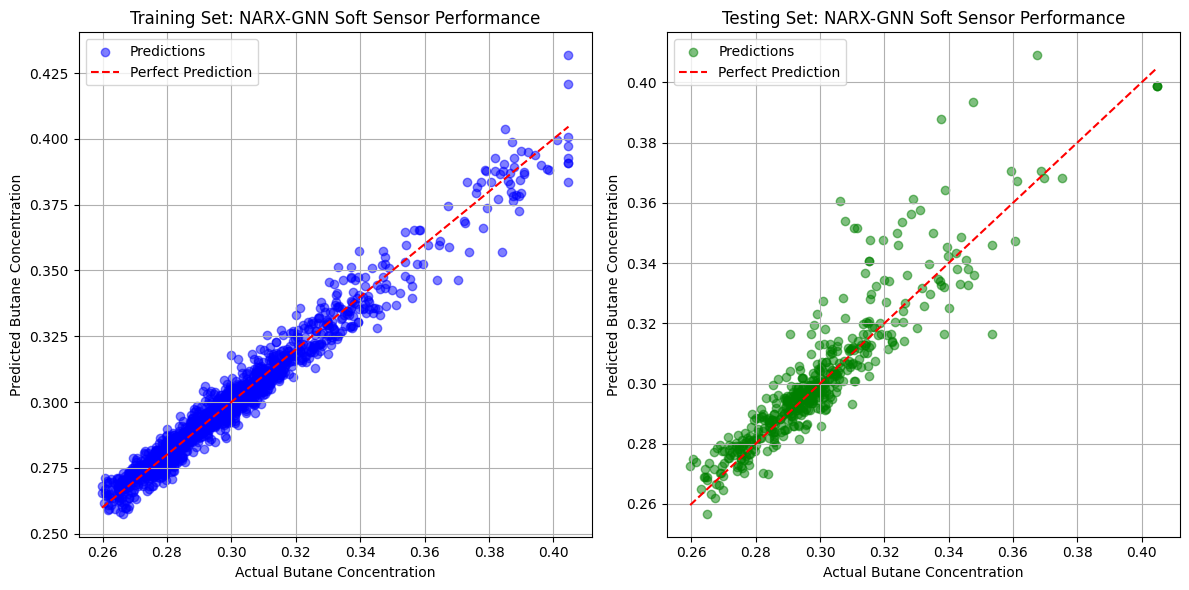

In [841]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Inverse transform predictions
pred_train_orig = scaler_y.inverse_transform(pred_train.view(-1, 1).numpy())
pred_test_orig = scaler_y.inverse_transform(pred_test.view(-1, 1).numpy())

# Inverse transform true values
y_train_orig = scaler_y.inverse_transform(data_train.y.view(-1, 1).numpy())
y_test_orig = scaler_y.inverse_transform(data_test.y.view(-1, 1).numpy())


# Calculate R² and RMSE for training set
r2_train = r2_score(y_train_orig, pred_train_orig)
rmse_train = np.sqrt(mean_squared_error(y_train_orig, pred_train_orig))

print(f"Training R² Score: {r2_train:.4f}")
print(f"Training RMSE: {rmse_train:.4f}")

# Calculate R² and RMSE for testing set
r2_test = r2_score(y_test_orig, pred_test_orig)
rmse_test = np.sqrt(mean_squared_error(y_test_orig, pred_test_orig))

print(f"Testing R² Score: {r2_test:.4f}")
print(f"Testing RMSE: {rmse_test:.4f}")


# Visualize results
plt.figure(figsize=(12, 6))

# Plot training results
plt.subplot(1, 2, 1)
plt.scatter(y_train_orig, pred_train_orig, color='blue', alpha=0.5, label="Predictions")
plt.plot([y_train_orig.min(), y_train_orig.max()], [y_train_orig.min(), y_train_orig.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Actual Butane Concentration")
plt.ylabel("Predicted Butane Concentration")
plt.title("Training Set: NARX-GNN Soft Sensor Performance")
plt.legend()
plt.grid(True)

# Plot testing results
plt.subplot(1, 2, 2)
plt.scatter(y_test_orig, pred_test_orig, color='green', alpha=0.5, label="Predictions")
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Actual Butane Concentration")
plt.ylabel("Predicted Butane Concentration")
plt.title("Testing Set: NARX-GNN Soft Sensor Performance")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

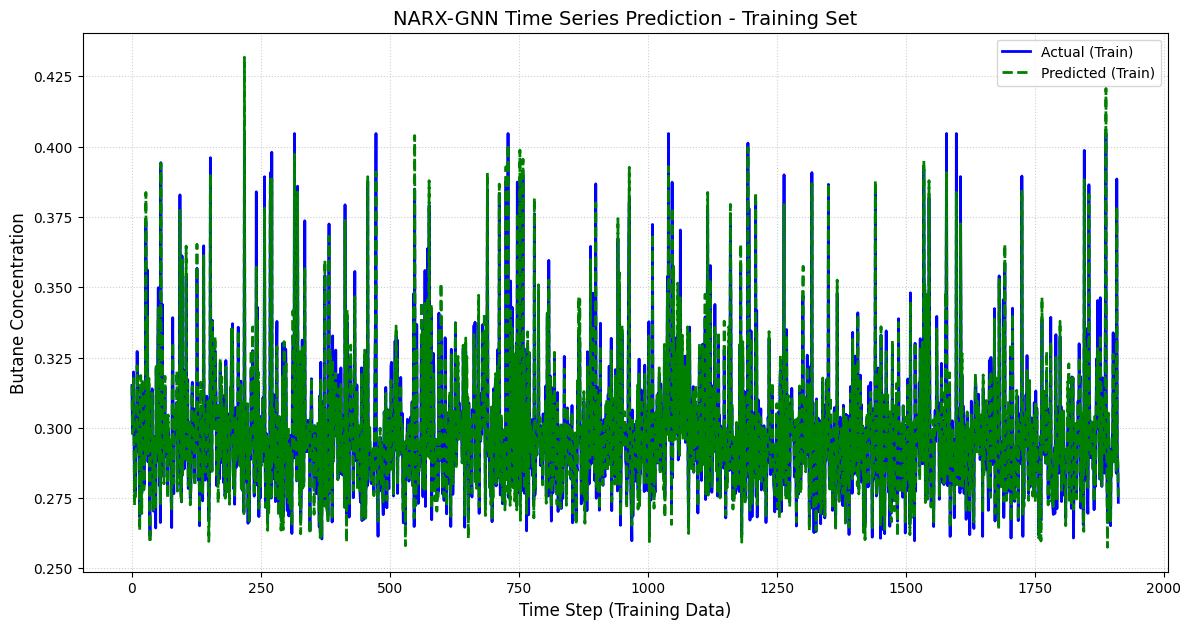

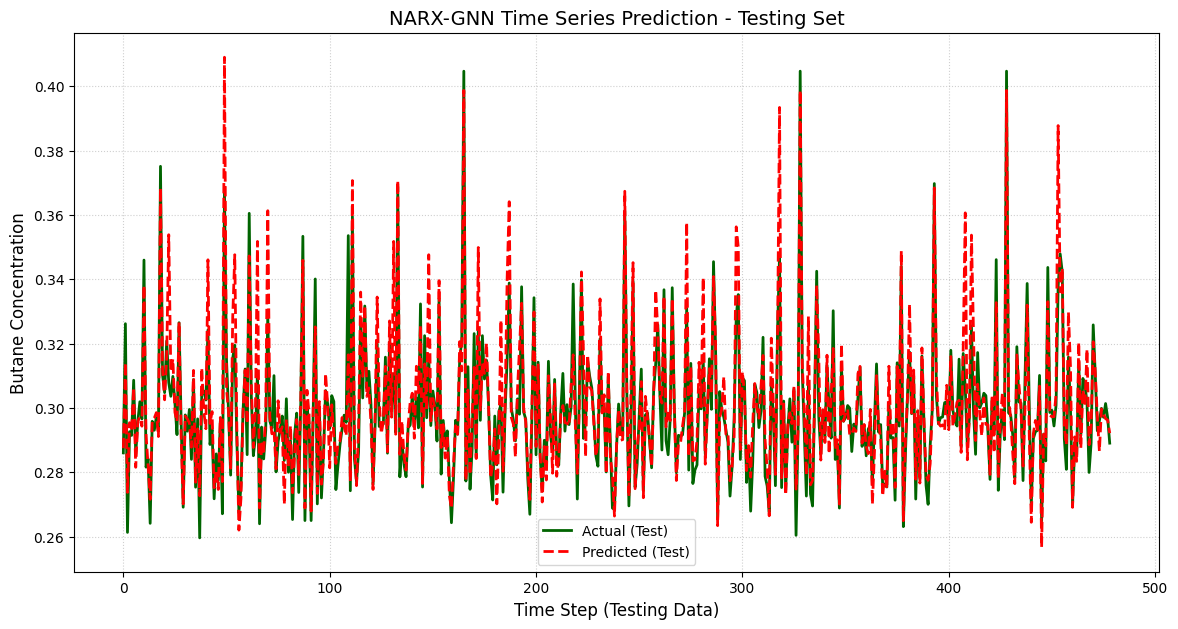

In [842]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Inverse Transform
# pred = scaler_y.inverse_transform(pred.view(-1, 1).numpy()) # Redundant line removed
# y_true = scaler_y.inverse_transform(data.y.view(-1, 1).numpy()) # Use training data instead

# Use the inverse transformed training data for plotting
y_true_train = y_train_orig
pred_train = pred_train_orig

# Create time axis for the training data
time_axis_train = np.arange(len(y_true_train))

# Plot actual vs. predicted over time for the training set
plt.figure(figsize=(14, 7)) # Increased figure size
plt.plot(time_axis_train, y_true_train, label="Actual (Train)", color='blue', linewidth=2) # Darker color, thicker line
plt.plot(time_axis_train, pred_train, label="Predicted (Train)", color='green', linestyle='--', linewidth=2) # Different color, dashed line
plt.xlabel("Time Step (Training Data)", fontsize=12) # Increased label font size
plt.ylabel("Butane Concentration", fontsize=12) # Increased label font size
plt.title("NARX-GNN Time Series Prediction - Training Set", fontsize=14) # Increased title font size
plt.legend(fontsize=10) # Increased legend font size
plt.grid(True, linestyle=':', alpha=0.6) # Added dashed grid
plt.show()

# Optionally, you can create a separate plot for the testing set as well
# Use the inverse transformed testing data for plotting
y_true_test = y_test_orig
pred_test = pred_test_orig

# Create time axis for the testing data
time_axis_test = np.arange(len(y_true_test))

# Plot actual vs. predicted over time for the testing set
plt.figure(figsize=(14, 7)) # Increased figure size
plt.plot(time_axis_test, y_true_test, label="Actual (Test)", color='darkgreen', linewidth=2) # Darker color, thicker line
plt.plot(time_axis_test, pred_test, label="Predicted (Test)", color='red', linestyle='--', linewidth=2) # Different color, dashed line
plt.xlabel("Time Step (Testing Data)", fontsize=12) # Increased label font size
plt.ylabel("Butane Concentration", fontsize=12) # Increased label font size
plt.title("NARX-GNN Time Series Prediction - Testing Set", fontsize=14) # Increased title font size
plt.legend(fontsize=10) # Increased legend font size
plt.grid(True, linestyle=':', alpha=0.6) # Added dashed grid
plt.show()